In [12]:
import numpy as np
import math
import csv
from proj1_helpers import *
from Hadrien import *
from Anaconda1 import *
from features_engineering import *
from correlation import *
import matplotlib.pyplot as plt



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load Data

In [13]:
y, tx, ids = load_csv_data("data_csv/train.csv")
#y, tx, ids = load_csv_data("data_csv/train.csv")
print("y has shape {0}".format(y.shape))
print("X has shape {0}".format(tx.shape))

y has shape (250000,)
X has shape (250000, 30)


-> we can observe some (3 at all) different patterns of NAN values -> essayer de déterminer si ces values ont une corrélation avec le label:
- pattern 1: feature 0: 840 NAN -> 16.8% NAN
- pattern 2: features 23,24,25: 1985 NAN -> 39.7% NAN
- pattern 3: features 4,5,6,12,26,27,28: 3525 NAN -> 70.5 % NAN


Also :
- 562 samples de p1 font parti de p2.
- 734 samples de p1 font parti de p3.
- 0 samples de p2 font parti de p1.
- 1423 sample de p2 font parti de p3
- 0 samples de p3 font parti de p1.
- 0 samples de p3 font parti de p2.

Also:
- p2 inter p3 = 1985
- p1 union p3 union p2 = 3631

## Mets les outliers à NAN

In [14]:
tx_nan = transform_to_nan(tx, -900)

## Feature 22 engineering

In [15]:
txx = tx_nan.copy()

#ajoute des vecteurs booleens pour chaque valeur (0.0, 1.0, 2.0 ou 3.0) de la feature 22
tx0 = new_feature_PRI_jet_num(txx, 0.0)
tx1 = new_feature_PRI_jet_num(tx0, 1.0)
tx2 = new_feature_PRI_jet_num(tx1, 2.0)
tx3 = new_feature_PRI_jet_num(tx2, 3.0)

#enlever la colonne de la feature 22 with "delete(matrice, indice, colonne = 1)"
tx3_final = np.delete(tx3, 22, 1)

xx = tx3_final.copy()

## Divise DATAset depending on NAN patterns

In [16]:
from NAN_Pattern_Decomposition import decompose_dataset_according_to_NAN_pattern

p0_ind, p0, y0, p1_ind, p1, y1, p2_ind, p2, y2, p3_ind, p3, y3 = decompose_dataset_according_to_NAN_pattern(xx, y, [0,23,27])

## Supprimer les colonnes avec NAN

In [17]:
feature_nans_1 = [0]
p1_processed = np.delete(p1, feature_nans_1, axis = 1)
print(p1_processed.shape)

feature_nans_2 = [4, 5, 6, 12, 22, 23, 24, 25, 26, 27]
p2_processed = np.delete(p2, feature_nans_2, axis = 1)
print(p2_processed.shape)

feature_nans_3 = [4, 5, 6, 12, 25, 26, 27]
p3_processed = np.delete(p3, feature_nans_3, axis = 1)
print(p3_processed.shape)

(38114, 32)
(73790, 23)
(69982, 26)


## Put NAN at mean

In [18]:
p0_nan_mean, mean =transform_to_mean(p0)
p1_nan_mean, mean =transform_to_mean(p1_processed)
p2_nan_mean, mean =transform_to_mean(p2_processed)
p3_nan_mean, mean =transform_to_mean(p3_processed)
#warning parce qu'on a des colonnes remplies de NAN
print(p0_nan_mean.shape)

(68114, 33)


# Feature Engineering

#### -> ajouter a la fin de la matrice de chaque groupe les differentes transformations

In [19]:
def add_feature_eng(dataset):
    
    tx_ = dataset.copy()
    (l,c) = np.shape(dataset)
    features = list(range(c))
    #features = list(range(30-1))   #-1 car on a enleve la colonne 22     

    # ajouter sin
    tx_sin = transform_feature_sin(tx_, features)
    print(np.shape(tx_sin))

    #ajouter cos
    tx_cos = transform_feature_cos(tx_sin, features)
    print(np.shape(tx_cos))

    #ajouter log
    tx_log = transform_feature_log(tx_cos, features)
    print(np.shape(tx_log))

    #ajouter x^2
    tx_pow2 = transform_feature_power(tx_log, features, 2)
    print(np.shape(tx_pow2))

    #ajouter x^3
    tx_pow3 = transform_feature_power(tx_pow2, features, 3)
    print(np.shape(tx_pow3))

    #ajouter sqrt
    tx_sqrt = transform_feature_sqrt(tx_pow3, features)
    print(np.shape(tx_sqrt))
    
    #standardize
    tx_stand, tx_mean, tx_std = standardize(tx_sqrt)
    
    dataset_eng = tx_stand.copy()
    
    return dataset_eng

# Ridge Regression

In [20]:
from train_model import *

### p0

In [21]:
#colonnes 29 et 30 de la p0 ne contiennent que des 0 -> delete ces deux colonnes!
p0_nan_mean_moins30 = np.delete(p0_nan_mean, 30, 1)
p0_nan_mean_moins29 = np.delete(p0_nan_mean_moins30, 29, 1)

print(p0_nan_mean_moins29.shape)

p0_eng = add_feature_eng(p0_nan_mean_moins29)
ws0 = prediction_ridge_lambda_fixed(p0_eng, y0, 0.8, 1000, 0.00000001)
#print(ws0)

print(p0_eng.shape)

#ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p0_eng)
a = np.ones((l,1), float)
p0_eng_plus = np.c_[a, p0_eng]

losses0, ws_l_0 = log_stochastic_gradient_descent(y0, p0_eng_plus, np.zeros(p0_eng_plus.shape[1]), 1, 1000, 1e-10)
#si converge -> dernier w qui est le meilleur: 
ws_l_0_best = ws_l_0[-1]


(68114, 31)
(68114, 62)
(68114, 93)
(68114, 124)
(68114, 155)
(68114, 186)
(68114, 217)
(68114, 217)
SGD(0/999): loss=0.6931471805589208, w0=0.0, w1=0.0
SGD(200/999): loss=0.6931471616303666, w0=-9.000000136163706e-10, w1=-1.0006255337889734e-09
SGD(400/999): loss=0.6931471474860045, w0=-2.3000000354727037e-09, w1=-2.5984268116313575e-09
SGD(600/999): loss=0.6931471285742841, w0=-3.200000037726224e-09, w1=-2.6188248228477176e-09
SGD(800/999): loss=0.6931471067306839, w0=-3.2000000939796618e-09, w1=-3.494478596518156e-09
SGD(999/999): loss=0.6931470901039526, w0=-3.1500001965523916e-09, w1=-4.5032828385595634e-09


In [22]:
#garder les meilleurs weight pour chaque feature 
w = ws_l_0_best.copy()
w_best0 = np.zeros(32)
indices_good_features0 = np.zeros(32)
print(len(w))
w_best0[0] = w[0]
liste = list(range(1,32))
transformation = list(range(6))
for i in liste:
    col = i
    for j in transformation:
        #si on en est à la première transformation -> initialiser le premier élément de w à cette valeur
        if(j == 0):
            w_best0[i] = w[col]
            indices_good_features0[i] = col
        elif(w[col] > w_best0[j]):
            w_best0[i] = w[col]
            indices_good_features0[i] = col
        col = (j*31)+i

print(indices_good_features0)
print(len(w_best0))
print(w_best0)

#reconstruire nouvelle matrice
f = len(indices_good_features0)
(l,c) = p0_eng_plus.shape
p0_best_final = np.zeros((l, f))
for indice, col in enumerate(np.int0(indices_good_features0)):
    p0_best_final[:,indice] =  p0_eng_plus[:, col]

218
[  0.   1. 126. 127.  97.  36.   6. 100. 101. 102. 103. 104.  74.  75.
  14. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120.
 121. 122.  92. 124.]
32
[-3.20000019e-09 -4.56324649e-09  8.74360184e-09  1.41056432e-09
 -5.25495293e-09  1.31225836e-08 -1.46466326e-08  1.47625703e-08
 -3.31645426e-09  9.18370309e-09  9.53919816e-10  7.83173782e-09
  8.67640485e-09  1.44194392e-08 -7.73938236e-09 -2.99472592e-10
  1.73805420e-09 -2.44250584e-10  3.16398485e-10 -6.03178532e-10
 -3.22847742e-09  2.55666057e-09  3.10846550e-09 -5.39437325e-11
  2.34563101e-09 -4.78945066e-10  1.05324829e-09  4.64103286e-09
 -1.66699465e-09  2.48691624e-09  9.84675091e-09  9.84675091e-09]


### p1

In [23]:
p1_eng = add_feature_eng(p1_nan_mean)
ws1 = prediction_ridge_lambda_fixed(p1_eng, y1, 0.8, 1000, 0.00000001)
#print(ws1)
print(p1_nan_mean.shape)

##ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p1_eng)
a = np.ones((l,1), float)
p1_eng_plus = np.c_[a, p1_eng]

losses1, ws_l_1 = log_stochastic_gradient_descent(y1, p1_eng_plus, np.zeros(p1_eng_plus.shape[1]), 1, 1000, 0.00001)
#si converge -> dernier w qui est le meilleur: 
ws_l_1_best = ws_l_1[-1]

(38114, 64)
(38114, 96)
(38114, 128)
(38114, 160)
(38114, 192)
(38114, 224)
(38114, 32)
SGD(0/999): loss=0.6931471805594103, w0=0.0, w1=0.0
SGD(200/999): loss=0.6926278826847672, w0=-0.0008697418149374383, w1=1.7643983497966803e-05
SGD(400/999): loss=0.6920929783458116, w0=-0.0017991726199251949, w1=-7.405851161702292e-05
SGD(600/999): loss=0.6914191073647334, w0=-0.002638203842485265, w1=-1.6907395116184216e-05
SGD(800/999): loss=0.6908287024154313, w0=-0.003417284292985743, w1=-8.844599812174957e-05
SGD(999/999): loss=0.6902062007748065, w0=-0.004220257301917209, w1=-0.0002725693992254954


In [24]:
#garder les meilleurs weight pour chaque feature 
w = ws_l_1_best.copy()
w_best1 = np.zeros(33)
indices_good_features1 = np.zeros(33)
print(len(w))
#print(w)
w_best1[0] = w[0]
liste = list(range(1,33))
transformation = list(range(6))
for i in liste:
    col = i
    for j in transformation:
        #si on en est à la première transformation -> initialiser le premier élément de w à cette valeur
        if(j == 0):
            w_best1[i] = w[col]
            indices_good_features1[i] = col
        elif(w[col] > w_best1[j]):
            w_best1[i-1] = w[col]
            indices_good_features1[i] = col
        col = (j*32)+i

print(len(w_best1))
print(w_best1)
print(indices_good_features1)

#reconstruire nouvelle matrice
f = len(indices_good_features1)
(l,c) = p1_eng_plus.shape
p1_best_final = np.zeros((l, f))
for indice, col in enumerate(np.int0(indices_good_features1)):
    p1_best_final[:,indice] =  p1_eng_plus[:, col]

225
33
[-4.22524788e-03  5.54556706e-05  2.19011131e-05 -2.06802412e-04
 -3.95309003e-04  4.34418049e-04  1.64264959e-05 -2.85250123e-04
  4.72743184e-05  4.60506117e-04  1.00160613e-04 -1.83998193e-04
 -4.05091662e-05  4.26908564e-05  1.25352490e-04 -1.81133094e-04
  1.43822892e-04 -1.45095847e-04  3.25179187e-04 -1.26915466e-04
 -2.66797960e-04  4.69500413e-05  8.90034384e-05  6.44932111e-05
  2.52916499e-04  1.27197059e-04  9.93531805e-05 -2.66775988e-04
  2.37660023e-04  3.06351848e-05 -3.17820923e-04 -1.94925124e-04
 -1.94925124e-04]
[  0.   1.  34. 131. 100. 133. 102. 103. 104.  73. 106. 107. 108.  77.
 110. 111. 112. 113. 114.  83. 116. 117. 118. 119. 120. 121. 122. 123.
 124. 125. 126. 127. 128.]


### p2

In [25]:
#colonnes 18-22 de la p2 ne contiennent que des 0 -> delete ces deux colonnes!
p2_nan_mean_moins22 = np.delete(p2_nan_mean, 22, 1)
p2_nan_mean_moins21 = np.delete(p2_nan_mean_moins22, 21, 1)
p2_nan_mean_moins20 = np.delete(p2_nan_mean_moins21, 20, 1)
p2_nan_mean_moins19 = np.delete(p2_nan_mean_moins20, 19, 1)
p2_nan_mean_moins18 = np.delete(p2_nan_mean_moins19, 18, 1)

p2_eng = add_feature_eng(p2_nan_mean_moins18)
ws2 = prediction_ridge_lambda_fixed(p2_eng, y2, 0.8, 1000, 0.00000001)
#print(ws2)

print(p2_nan_mean.shape)

##ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p2_eng)
a = np.ones((l,1), float)
p2_eng_plus = np.c_[a, p2_eng]

losses2, ws_l_2 = log_stochastic_gradient_descent(y2, p2_eng_plus, np.zeros(p2_eng_plus.shape[1]), 1, 1000, 0.00001)
#si converge -> dernier w qui est le meilleur: 
ws_l_2_best = ws_l_2[-1]

(73790, 36)
(73790, 54)
(73790, 72)
(73790, 90)
(73790, 108)
(73790, 126)
(73790, 23)
SGD(0/999): loss=0.6931471805588729, w0=0.0, w1=0.0
SGD(200/999): loss=0.6918347592347659, w0=-0.00035994826469122284, w1=0.0001755849463741321
SGD(400/999): loss=0.6906277485136528, w0=-0.0006200040856378107, w1=0.0002481682386591697
SGD(600/999): loss=0.689489466120307, w0=-0.0009994526995203052, w1=0.0002881550894806351
SGD(800/999): loss=0.6882143198960124, w0=-0.0013480449861708148, w1=0.00031068127546071575
SGD(999/999): loss=0.6870558029450737, w0=-0.00176142563471021, w1=0.0003005997552207891


In [26]:
#garder les meilleurs weight pour chaque feature 
w = ws_l_2_best.copy()
w_best2 = np.zeros(24)
indices_good_features2 = np.zeros(24)
print(len(w))
#print(w)
w_best2[0] = w[0]
liste = list(range(1,24))
transformation = list(range(6))
for i in liste:
    col = i
    for j in transformation:
        #si on en est à la première transformation -> initialiser le premier élément de w à cette valeur
        if(j == 0):
            w_best2[i] = w[col]
            indices_good_features2[i] = col
        elif(w[col] > w_best2[j]):
            w_best2[i-1] = w[col]
            indices_good_features2[i] = col
        col = (j*23)+i

print(len(w_best2))
print(w_best2)
print(indices_good_features2)

#reconstruire nouvelle matrice
f = len(indices_good_features2)
(l,c) = p2_eng_plus.shape
p2_best_final = np.zeros((l, f))
for indice, col in enumerate(np.int0(indices_good_features2)):
    p2_best_final[:,indice] =  p2_eng_plus[:, col]

127
24
[ 4.30459531e-04  1.99436694e-03  2.91132036e-05  5.72802954e-04
  1.61751080e-04  1.38046156e-03 -4.08515562e-05  1.12115120e-04
  1.99317085e-03  1.82398502e-03  1.71756493e-03  3.45508212e-05
 -2.69875796e-04  5.09444835e-04  2.08711610e-04  1.04283962e-03
  7.40440676e-04  2.00804659e-03 -2.41198585e-04 -3.36230603e-06
  8.06090309e-04  5.21263464e-04  1.08389639e-03  3.28433413e-04]
[  0.  93.   2.  95.  73.  97.  98.   7.  31.   9.  56.  80.  12.  13.
  83.  38.  85.  86. 110.  19.  20.  67.  91.  92.]


### p3

In [27]:
#colonnes  de la p3 ne contiennent que des 0 -> delete ces deux colonnes!
#p3_nan_mean = np.delete(p3_nan_mean, 26, 1)
p3_nan_mean_moins25 = np.delete(p3_nan_mean, 25, 1)
p3_nan_mean_moins24 = np.delete(p3_nan_mean_moins25, 24, 1)
p3_nan_mean_moins23 = np.delete(p3_nan_mean_moins24, 23, 1)
p3_nan_mean_moins22 = np.delete(p3_nan_mean_moins23, 22, 1)

p3_eng = add_feature_eng(p3_nan_mean_moins22)
ws3 = prediction_ridge_lambda_fixed(p3_eng, y3, 0.8, 1000, 0.00000001)
#print(ws3)

print(p3_nan_mean_moins22.shape)

##ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p3_eng)
a = np.ones((l,1), float)
p3_eng_plus = np.c_[a, p3_eng]

losses3, ws_l_3 = log_stochastic_gradient_descent(y3, p3_eng_plus, np.zeros(p3_eng_plus.shape[1]), 1, 1000, 0.00001)
#si converge -> dernier w qui est le meilleur: 
ws_l_3_best = ws_l_3[-1]

(69982, 44)
(69982, 66)
(69982, 88)
(69982, 110)
(69982, 132)
(69982, 154)
(69982, 22)
SGD(0/999): loss=0.6931471805589041, w0=0.0, w1=0.0
SGD(200/999): loss=0.6924450523558151, w0=-0.0002699117125602831, w1=-5.406309128341358e-05
SGD(400/999): loss=0.6916518318870016, w0=-0.0004596732332261264, w1=-1.732156504444151e-06
SGD(600/999): loss=0.6909905548322965, w0=-0.0006489610881299117, w1=7.376416353566558e-05
SGD(800/999): loss=0.6901064906452452, w0=-0.0007790348982358772, w1=0.00019868501273572663
SGD(999/999): loss=0.6895268734280895, w0=-0.0010928949342058453, w1=0.00023055671619759754


In [28]:
#garder les meilleurs weight pour chaque feature 
w = ws_l_3_best.copy()
w_best3 = np.zeros(23)
indices_good_features3 = np.zeros(23)
print(len(w))
#print(w)
w_best3[0] = w[0]
liste = list(range(1,23))
transformation = list(range(6))
for i in liste:
    col = i
    for j in transformation:
        #si on en est à la première transformation -> initialiser le premier élément de w à cette valeur
        if(j == 0):
            w_best3[i] = w[col]
            indices_good_features3[i] = col
        elif(w[col] > w_best3[j]):
            w_best3[i-1] = w[col]
            indices_good_features3[i] = col
        col = (j*22)+i

print(len(w_best3))
print(w_best3)
print(indices_good_features3)

#reconstruire nouvelle matrice
f = len(indices_good_features3)
(l,c) = p3_eng_plus.shape
p3_best_final = np.zeros((l, f))
for indice, col in enumerate(np.int0(indices_good_features3)):
    p3_best_final[:,indice] =  p3_eng_plus[:, col]

155
23
[ 5.29822984e-04  1.13884659e-03  7.64642551e-04 -4.63529291e-04
  3.12019711e-04 -2.51671888e-04  2.46950705e-05  6.48835894e-04
  4.06715260e-04 -3.20237042e-05  6.61137319e-04 -1.45806340e-04
  4.48247050e-04  4.28844139e-04  9.39654583e-05  5.10749811e-05
 -5.98688851e-05 -3.80068018e-05 -1.03953851e-04  3.35809597e-04
  1.20012356e-04 -1.03972645e-04 -6.19185561e-04]
[  0.  89.  90.  91.  70.  93.  50.  51.  96.  53.  54.  99. 100. 101.
 102. 103.  60. 105.  62.  63.  86. 109.  66.]


## This is a  TEST

## p0

SGD(0/9999): loss=0.6931471805596882, w0=0.0, w1=0.0
SGD(2000/9999): loss=0.46199463944942537, w0=-0.674163814042271, w1=-0.0013793481072877007
SGD(4000/9999): loss=0.3688401096547983, w0=-1.1019472693563188, w1=-0.0014423603721544843
SGD(6000/9999): loss=0.32523300039446834, w0=-1.3944672956200632, w1=0.0038336013191134603
SGD(8000/9999): loss=0.30153666357976044, w0=-1.614455790051753, w1=0.0026119846087522994
SGD(9999/9999): loss=0.2885360305993867, w0=-1.775512721025781, w1=0.0014248833905025791
SGD(0/9999): loss=0.6931471805596882, w0=0.0, w1=0.0
SGD(2000/9999): loss=0.26868187109618813, w0=-2.2168312209276695, w1=0.010719523740916947
SGD(4000/9999): loss=0.2655622961682285, w0=-2.4323640154780457, w1=-0.014318622744918227
SGD(6000/9999): loss=0.26509238028027227, w0=-2.5111756770669755, w1=-0.013939673826609588
SGD(8000/9999): loss=0.2651285020723147, w0=-2.535652013550203, w1=0.005165783297726314
SGD(9999/9999): loss=0.26586902746013696, w0=-2.526287445576657, w1=-0.014654744025

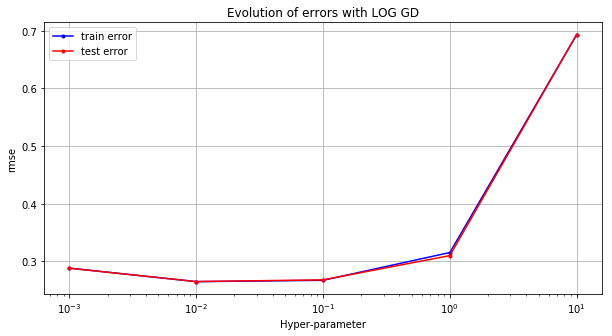

In [44]:
from train_model import *
max_iter = 10000
initial_w = np.zeros(p0_best_final.shape[1])
logistic_stochastic_gradient_descent_exploration(y1, p0_best_final, 0.8, np.logspace(-3, 1, 10), 10, initial_w, max_iter)

In [29]:
x_tr,x_te,y_tr,y_te=split_data(p0_best_final,y0,0.8)

In [30]:
initial_w_gd = np.zeros(p0_best_final.shape[1])
max_iters = 20000
batch=10
gamma = 0.01
gd_l0,gd_w0=log_stochastic_gradient_descent(y_tr, x_tr, initial_w_gd, batch, max_iters, gamma)

SGD(0/19999): loss=0.6931471805590762, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.5143298465494041, w0=-0.19353060576175785, w1=-0.09259328861033694
SGD(8000/19999): loss=0.5066817645779639, w0=-0.22310553204660138, w1=-0.06913807817846425
SGD(12000/19999): loss=0.5055834068220996, w0=-0.19870899703398334, w1=-0.043623696693593214
SGD(16000/19999): loss=0.5041421232865754, w0=-0.22320339097728067, w1=-0.06653773646695778
SGD(19999/19999): loss=0.5037413482995272, w0=-0.2692388428948318, w1=-0.07457178428516054


In [31]:
l,wnew0=minimum_loss_vector(gd_l0, gd_w0)
l,wnew0.shape

(0.5037413482995272, (32,))

In [32]:
y_pred1=predict_labels(wnew0, x_tr)

accuracy_calculator(y_pred1, y_tr)

0.7533170615330972

In [33]:
y_pred2=predict_labels(wnew0, x_te)

accuracy_calculator(y_pred2, y_te)

0.7530646700433091

## p1

SGD(0/19999): loss=0.6931471805596882, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.35048273194527924, w0=-1.1059055608370438, w1=-0.13676726724170685
SGD(8000/19999): loss=0.27515721173769564, w0=-1.628428818283291, w1=-0.21064960198618443
SGD(12000/19999): loss=0.24806191512487252, w0=-1.9326962588865548, w1=-0.27542857071614624
SGD(16000/19999): loss=0.23535575761336633, w0=-2.130826944928512, w1=-0.32521376997353235
SGD(19999/19999): loss=0.22805457172084215, w0=-2.277231918782596, w1=-0.367586503919329
SGD(0/19999): loss=0.6931471805596882, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.24540619898677668, w0=-1.97633049026174, w1=-0.27030534148001606
SGD(8000/19999): loss=0.22271510813265843, w0=-2.4081761750380135, w1=-0.40401339708682954
SGD(12000/19999): loss=0.216595635403088, w0=-2.6135382604218482, w1=-0.4787925715264433
SGD(16000/19999): loss=0.21407823844299395, w0=-2.7359195207777183, w1=-0.5070319458016599
SGD(19999/19999): loss=0.2129499273767488, w0=-2.8078268368245816, w1=-0.518599

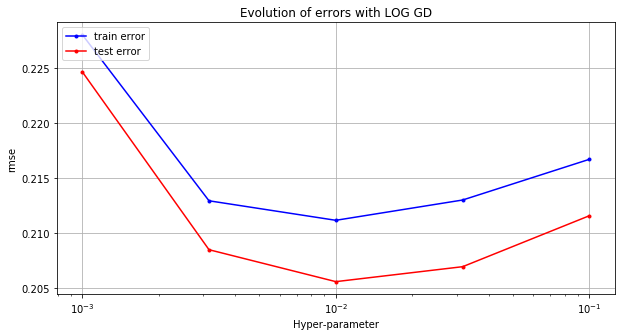

In [52]:
from train_model import *
max_iter = 20000
initial_w = np.zeros(p1_best_final.shape[1])
logistic_stochastic_gradient_descent_exploration(y1, p1_best_final, 0.8, np.logspace(-3, -1, 5), 10, initial_w, max_iter)

In [34]:
x_tr,x_te,y_tr,y_te=split_data(p1_best_final,y1,0.8)

In [35]:
initial_w_gd = np.zeros(p1_best_final.shape[1])
max_iters = 20000
batch=10
gamma = 0.01
gd_l1,gd_w1=log_stochastic_gradient_descent(y_tr, x_tr, initial_w_gd, batch, max_iters, gamma)

l,wnew1=minimum_loss_vector(gd_l1, gd_w1)
l,wnew1.shape

SGD(0/19999): loss=0.6931471805596882, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.21624838589993983, w0=-2.6508795987820224, w1=-0.49996225452461995
SGD(8000/19999): loss=0.21220253727931038, w0=-2.9019218086003917, w1=-0.5291795572528779
SGD(12000/19999): loss=0.21181657075942967, w0=-2.972047766508642, w1=-0.5873273697456934
SGD(16000/19999): loss=0.21152962785554338, w0=-3.0026227211127936, w1=-0.5190798118981849
SGD(19999/19999): loss=0.21162624254461854, w0=-3.021849843669504, w1=-0.5908848852367451


(0.21152962785554338, (33,))

In [36]:
y_pred3=predict_labels(wnew1, x_te)

In [37]:
accuracy_calculator(y_pred3, y_te)

0.9319165682802046

## p2

SGD(0/19999): loss=0.6931471805590165, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.5248468461589261, w0=-0.4629595549247022, w1=0.05186692920139082
SGD(8000/19999): loss=0.5027098014581459, w0=-0.6835699330248468, w1=0.10482415140965409
SGD(12000/19999): loss=0.4937000881566651, w0=-0.800124265147376, w1=0.16517320323454185
SGD(16000/19999): loss=0.4884415138380423, w0=-0.8795982077863571, w1=0.2148972889658992
SGD(19999/19999): loss=0.4849441671792609, w0=-0.9226368248374357, w1=0.25887359921725916
SGD(0/19999): loss=0.6931471805590165, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.4756535573912801, w0=-1.0257634436384713, w1=0.42149072499348667
SGD(8000/19999): loss=0.4644411214414183, w0=-1.0971857378141836, w1=0.7513208111252161
SGD(12000/19999): loss=0.4595016932233451, w0=-1.132455258505456, w1=0.9899318822423544
SGD(16000/19999): loss=0.4558372309950904, w0=-1.1533336032384849, w1=1.1965030579986355
SGD(19999/19999): loss=0.4544253898862201, w0=-1.1671297225986728, w1=1.2415735459731296
SGD

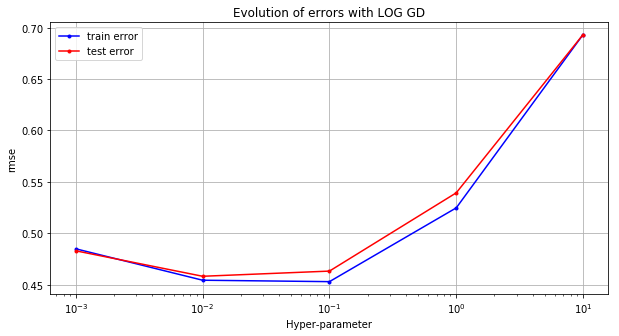

In [57]:
from train_model import *
max_iter = 20000
initial_w = np.zeros(p2_best_final.shape[1])
logistic_stochastic_gradient_descent_exploration(y2, p2_best_final, 0.8, np.logspace(-3, 1, 5), 10, initial_w, max_iter)

In [38]:
x_tr,x_te,y_tr,y_te=split_data(p2_best_final,y2,0.8)

In [39]:
initial_w_gd = np.zeros(p2_best_final.shape[1])
max_iters = 20000
batch=10
gamma = 0.01
gd_l2,gd_w2=log_stochastic_gradient_descent(y_tr, x_tr, initial_w_gd, batch, max_iters, gamma)

l,wnew2=minimum_loss_vector(gd_l2, gd_w2)
l,wnew2.shape

SGD(0/19999): loss=0.6931471805590165, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.47692301471179593, w0=-0.9651742013297794, w1=0.33017084935311036
SGD(8000/19999): loss=0.465553588904163, w0=-1.0753788415213565, w1=0.6125626196531743
SGD(12000/19999): loss=0.45921809350736303, w0=-1.0881509444735418, w1=0.8672287712861759
SGD(16000/19999): loss=0.4562263985890115, w0=-1.1624060360490551, w1=1.0446196006840678
SGD(19999/19999): loss=0.4547371195549916, w0=-1.1858006211137504, w1=1.2125467607027018


(0.4547371195549916, (24,))

In [40]:
y_pred4=predict_labels(wnew2, x_te)

In [41]:
accuracy_calculator(y_pred4, y_te)

0.7925193115598319

## p3

SGD(0/1999): loss=0.6931471805590554, w0=0.0, w1=0.0
SGD(400/1999): loss=0.675788947172212, w0=-0.04134486465050728, w1=0.006570572372172062
SGD(800/1999): loss=0.6621595943855018, w0=-0.07818552473120614, w1=0.015662821908245854
SGD(1200/1999): loss=0.6518766764014545, w0=-0.11518656599434429, w1=0.018872975123311285
SGD(1600/1999): loss=0.6437629090383279, w0=-0.15066842298329527, w1=0.02130588192331098
SGD(1999/1999): loss=0.6373398014067396, w0=-0.17851922671531253, w1=0.023837069529182242
SGD(0/1999): loss=0.6931471805590554, w0=0.0, w1=0.0
SGD(400/1999): loss=0.6655340933968812, w0=-0.07206859552273936, w1=0.016247775277202267
SGD(800/1999): loss=0.6478462020917001, w0=-0.13492101872645812, w1=0.02366745288744891
SGD(1200/1999): loss=0.6356739400996593, w0=-0.18776382588315538, w1=0.024855849132349436
SGD(1600/1999): loss=0.6268709294502421, w0=-0.2353726775740581, w1=0.024925435093925898
SGD(1999/1999): loss=0.6201189750479553, w0=-0.2751860437764499, w1=0.027070858542011796
SGD

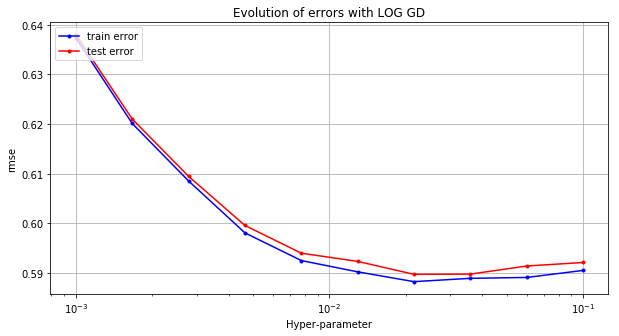

In [99]:
from train_model import *
max_iter = 2000
initial_w = np.zeros(p3_best_final.shape[1])
logistic_stochastic_gradient_descent_exploration(y3, p3_best_final, 0.8, np.logspace(-3, -1, 10), 10, initial_w, max_iter)

In [42]:
x_tr,x_te,y_tr,y_te=split_data(p3_best_final,y3,0.8)

In [43]:
initial_w_gd = np.zeros(p3_best_final.shape[1])
max_iters = 20000
batch=10
gamma = 0.015
gd_l3,gd_w3=log_stochastic_gradient_descent(y_tr, x_tr, initial_w_gd, batch, max_iters, gamma)

SGD(0/19999): loss=0.6931471805590554, w0=0.0, w1=0.0
SGD(4000/19999): loss=0.5856921481253429, w0=-0.6368590259221523, w1=0.0764201978177136
SGD(8000/19999): loss=0.5849284576027144, w0=-0.6565944805998638, w1=0.03863655356417721
SGD(12000/19999): loss=0.5847841384181269, w0=-0.6693158527375243, w1=-0.010008505587941665
SGD(16000/19999): loss=0.585040166121408, w0=-0.5745638132855012, w1=-0.05130626120553447
SGD(19999/19999): loss=0.584184599801044, w0=-0.6199576711855093, w1=-0.07047890313163946


In [44]:
l,wnew3=minimum_loss_vector(gd_l3, gd_w3)
l,wnew3.shape

(0.584184599801044, (23,))

In [45]:
y_pred5=predict_labels(wnew3, x_te)

In [46]:
accuracy_calculator(y_pred5, y_te)

0.6802171893977281

## Ridge Reg

## P0

Ridge Resgression, Loss : 0.275, Lambda : 1e-15


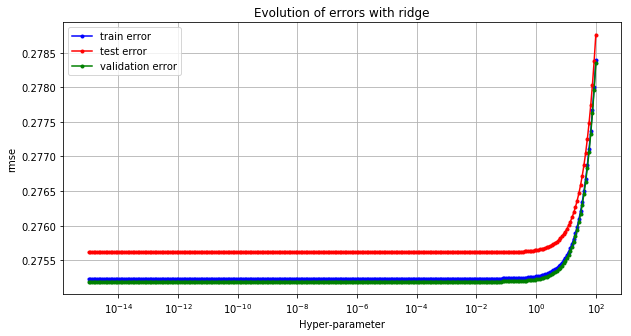

In [60]:
ridge_regression_exploration(y1, p0_best_final, 0.8, np.logspace(-15, 2, 300))

In [74]:
x_tr,x_te,y_tr,y_te=split_data(p0_best_final,y0,0.8)

In [87]:
w_r_0=ridge_regression(y_tr, x_tr, 100)

In [88]:
y_pred_r0=predict_labels(w_r_0, x_te)

In [89]:
accuracy_calculator(y_pred_r0, y_te)

0.7435953901490127

## P1

In [ ]:
ridge_regression_exploration(y1, p1_best_final, 0.8, np.logspace(-10, 4, 30))

In [90]:
x_tr,x_te,y_tr,y_te=split_data(p1_best_final,y1,0.8)

In [91]:
w_r_1=ridge_regression(y_tr, x_tr, 100)

In [92]:
y_pred_r1=predict_labels(w_r_1, x_te)

In [93]:
accuracy_calculator(y_pred_r1, y_te)

0.928374655647383

## P2

In [ ]:
ridge_regression_exploration(y1, p2_best_final, 0.8, np.logspace(-10, 4, 30))

In [52]:
x_tr,x_te,y_tr,y_te=split_data(p2_best_final,y2,0.8)

In [53]:
w_r_2=ridge_regression(y_tr, x_tr, 1e-15)

In [54]:
y_pred_r2=predict_labels(w_r_2, x_te)

In [55]:
accuracy_calculator(y_pred_r2, y_te)

0.7838460496002169

## P3

In [ ]:
ridge_regression_exploration(y1, p3_best_final, 0.8, np.logspace(-10, 4, 30))

In [94]:
x_tr,x_te,y_tr,y_te=split_data(p3_best_final,y3,0.8)

In [95]:
w_r_3=ridge_regression(y_tr, x_tr, 100)

In [96]:
y_pred_r3=predict_labels(w_r_3, x_te)

In [97]:
accuracy_calculator(y_pred_r3, y_te)

0.6735729084803886

In [98]:
w_r_3

array([-0.22956496, -0.05122577,  0.1864997 ,  0.15149867, -0.16195537,
       -0.12478674,  0.00067006, -0.00312488,  0.16487809,  0.09110426,
       -0.01416676,  0.06486945,  0.00215987, -0.13011346,  0.09693432,
        0.00148728,  0.00145995,  0.00517459, -0.00137401,  0.00344538,
        0.05127114,  0.00329506,  0.00353896])

## Test kaggle 

In [47]:
y_t, tx_t, ids_T = load_csv_data("data_csv/test.csv")

In [48]:
print("y has shape {0}".format(y_t.shape))
print("X has shape {0}".format(tx_t.shape))

y has shape (568238,)
X has shape (568238, 30)


In [49]:
tx_nan = transform_to_nan(tx_t, -900)

## Feature 22 engineering

txx_t = tx_nan.copy()

#ajoute des vecteurs booleens pour chaque valeur (0.0, 1.0, 2.0 ou 3.0) de la feature 22
tx0 = new_feature_PRI_jet_num(txx_t, 0.0)
tx1 = new_feature_PRI_jet_num(tx0, 1.0)
tx2 = new_feature_PRI_jet_num(tx1, 2.0)
tx3 = new_feature_PRI_jet_num(tx2, 3.0)

#enlever la colonne de la feature 22 with "delete(matrice, indice, colonne = 1)"
tx3_final = np.delete(tx3, 22, 1)

xx = tx3_final.copy()
print(xx.shape)
## Divise DATAset depending on NAN patterns

(568238, 33)


In [50]:
from NAN_Pattern_Decomposition import decompose_dataset_according_to_NAN_pattern

In [51]:
p0_ind, p0, y0, p1_ind, p1, y1, p2_ind, p2, y2, p3_ind, p3, y3 = decompose_dataset_according_to_NAN_pattern(xx, y_t, [0,23,27])

In [52]:
## Supprimer les colonnes avec NAN

feature_nans_1 = [0]
p1_processed = np.delete(p1, feature_nans_1, axis = 1)
print(p1_processed.shape)

feature_nans_2 = [4, 5, 6, 12, 22, 23, 24, 25, 26, 27]
p2_processed = np.delete(p2, feature_nans_2, axis = 1)
print(p2_processed.shape)

feature_nans_3 = [4, 5, 6, 12, 25, 26, 27]
p3_processed = np.delete(p3, feature_nans_3, axis = 1)
print(p3_processed.shape)

## Put NAN at mean

p0_nan_mean, mean =transform_to_mean(p0)
p1_nan_mean, mean =transform_to_mean(p1_processed)
p2_nan_mean, mean =transform_to_mean(p2_processed)
p3_nan_mean, mean =transform_to_mean(p3_processed)
#warning parce qu'on a des colonnes remplies de NAN
print(p0_nan_mean.shape)

(86488, 32)
(168195, 23)
(158095, 26)
(155460, 33)


In [53]:
# Feature Engineering

#### -> ajouter a la fin de la matrice de chaque groupe les differentes transformations

def add_feature_eng(dataset):
    
    tx_ = dataset.copy()
    (l,c) = np.shape(dataset)
    features = list(range(c))
    #features = list(range(30-1))   #-1 car on a enleve la colonne 22     

    # ajouter sin
    tx_sin = transform_feature_sin(tx_, features)
    print(np.shape(tx_sin))

    #ajouter cos
    tx_cos = transform_feature_cos(tx_sin, features)
    print(np.shape(tx_cos))

    #ajouter log
    tx_log = transform_feature_log(tx_cos, features)
    print(np.shape(tx_log))

    #ajouter x^2
    tx_pow2 = transform_feature_power(tx_log, features, 2)
    print(np.shape(tx_pow2))

    #ajouter x^3
    tx_pow3 = transform_feature_power(tx_pow2, features, 3)
    print(np.shape(tx_pow3))

    #ajouter sqrt
    tx_sqrt = transform_feature_sqrt(tx_pow3, features)
    print(np.shape(tx_sqrt))
    
    #standardize
    tx_stand, tx_mean, tx_std = standardize(tx_sqrt)
    
    dataset_eng = tx_stand.copy()
    
    return dataset_eng

In [54]:
# Ridge Regression

from train_model import *

### p0

#colonnes 29 et 30 de la p0 ne contiennent que des 0 -> delete ces deux colonnes!
p0_nan_mean_moins30 = np.delete(p0_nan_mean, 30, 1)
p0_nan_mean_moins29 = np.delete(p0_nan_mean_moins30, 29, 1)

print(p0_nan_mean_moins29.shape)

p0_eng = add_feature_eng(p0_nan_mean_moins29)
#ws0 = prediction_ridge_lambda_fixed(p0_eng, y0, 0.8, 1000, 0.00000001)
#print(ws0)

print(p0_eng.shape)

#ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p0_eng)
a = np.ones((l,1), float)
p0_eng_plus = np.c_[a, p0_eng]

#losses0, ws_l_0 = log_stochastic_gradient_descent(y0, p0_eng_plus, np.zeros(p0_eng_plus.shape[1]), 1, 1000, 1e-10)
#si converge -> dernier w qui est le meilleur: 
#ws_l_0_best = ws_l_0[-1]

(155460, 31)
(155460, 62)
(155460, 93)
(155460, 124)
(155460, 155)
(155460, 186)
(155460, 217)
(155460, 217)


In [55]:
"""
#garder les meilleurs weight pour chaque feature 
w = ws_l_0_best.copy()
w_best0 = np.zeros(32)
indices_good_features0 = np.zeros(32)
print(len(w))
w_best0[0] = w[0]
liste = list(range(1,32))
transformation = list(range(6))
for i in liste:
    col = i
    for j in transformation:
        #si on en est à la première transformation -> initialiser le premier élément de w à cette valeur
        if(j == 0):
            w_best0[i] = w[col]
            indices_good_features0[i] = col
        elif(w[col] > w_best0[j]):
            w_best0[i] = w[col]
            indices_good_features0[i] = col
        col = (j*31)+i

print(indices_good_features0)
print(len(w_best0))
print(w_best0)
"""
#reconstruire nouvelle matrice
f = len(indices_good_features0)
(l,c) = p0_eng_plus.shape
p0_best_final = np.zeros((l, f))
for indice, col in enumerate(np.int0(indices_good_features0)):
    p0_best_final[:,indice] =  p0_eng_plus[:, col]
print(p0_best_final.shape)

(155460, 32)


In [56]:
### p1

p1_eng = add_feature_eng(p1_nan_mean)
#ws1 = prediction_ridge_lambda_fixed(p1_eng, y1, 0.8, 1000, 0.00000001)
#print(ws1)
print(p1_nan_mean.shape)

##ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p1_eng)
a = np.ones((l,1), float)
p1_eng_plus = np.c_[a, p1_eng]

#losses1, ws_l_1 = log_stochastic_gradient_descent(y1, p1_eng_plus, np.zeros(p1_eng_plus.shape[1]), 1, 1000, 0.00001)
#si converge -> dernier w qui est le meilleur: 
#ws_l_1_best = ws_l_1[-1]
"""
#garder les meilleurs weight pour chaque feature 
w = ws_l_1_best.copy()
w_best1 = np.zeros(33)
indices_good_features1 = np.zeros(33)
print(len(w))
#print(w)
w_best1[0] = w[0]
liste = list(range(1,33))
transformation = list(range(6))
for i in liste:
    col = i
    for j in transformation:
        #si on en est à la première transformation -> initialiser le premier élément de w à cette valeur
        if(j == 0):
            w_best1[i] = w[col]
            indices_good_features1[i] = col
        elif(w[col] > w_best1[j]):
            w_best1[i-1] = w[col]
            indices_good_features1[i] = col
        col = (j*32)+i

print(len(w_best1))
print(w_best1)
print(indices_good_features1)
"""
#reconstruire nouvelle matrice
f = len(indices_good_features1)
(l,c) = p1_eng_plus.shape
p1_best_final = np.zeros((l, f))
for indice, col in enumerate(np.int0(indices_good_features1)):
    p1_best_final[:,indice] =  p1_eng_plus[:, col]
print(p1_best_final.shape)

(86488, 64)
(86488, 96)
(86488, 128)
(86488, 160)
(86488, 192)
(86488, 224)
(86488, 32)
(86488, 33)


In [57]:
### p2

#colonnes 18-22 de la p2 ne contiennent que des 0 -> delete ces deux colonnes!
p2_nan_mean_moins22 = np.delete(p2_nan_mean, 22, 1)
p2_nan_mean_moins21 = np.delete(p2_nan_mean_moins22, 21, 1)
p2_nan_mean_moins20 = np.delete(p2_nan_mean_moins21, 20, 1)
p2_nan_mean_moins19 = np.delete(p2_nan_mean_moins20, 19, 1)
p2_nan_mean_moins18 = np.delete(p2_nan_mean_moins19, 18, 1)

p2_eng = add_feature_eng(p2_nan_mean_moins18)
#ws2 = prediction_ridge_lambda_fixed(p2_eng, y2, 0.8, 1000, 0.00000001)
#print(ws2)

print(p2_nan_mean.shape)

##ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p2_eng)
a = np.ones((l,1), float)
p2_eng_plus = np.c_[a, p2_eng]
"""
losses2, ws_l_2 = log_stochastic_gradient_descent(y2, p2_eng_plus, np.zeros(p2_eng_plus.shape[1]), 1, 1000, 0.00001)
#si converge -> dernier w qui est le meilleur: 
ws_l_2_best = ws_l_2[-1]

#garder les meilleurs weight pour chaque feature 
w = ws_l_2_best.copy()
w_best2 = np.zeros(24)
indices_good_features2 = np.zeros(24)
print(len(w))
#print(w)
w_best2[0] = w[0]
liste = list(range(1,24))
transformation = list(range(6))
for i in liste:
    col = i
    for j in transformation:
        #si on en est à la première transformation -> initialiser le premier élément de w à cette valeur
        if(j == 0):
            w_best2[i] = w[col]
            indices_good_features2[i] = col
        elif(w[col] > w_best2[j]):
            w_best2[i-1] = w[col]
            indices_good_features2[i] = col
        col = (j*23)+i

print(len(w_best2))
print(w_best2)
print(indices_good_features2)
"""
#reconstruire nouvelle matrice
f = len(indices_good_features2)
(l,c) = p2_eng_plus.shape
p2_best_final = np.zeros((l, f))
for indice, col in enumerate(np.int0(indices_good_features2)):
    p2_best_final[:,indice] =  p2_eng_plus[:, col]
print(p2_best_final.shape)

(168195, 36)
(168195, 54)
(168195, 72)
(168195, 90)
(168195, 108)
(168195, 126)
(168195, 23)
(168195, 24)


In [58]:
### p3

#colonnes  de la p3 ne contiennent que des 0 -> delete ces deux colonnes!
#p3_nan_mean = np.delete(p3_nan_mean, 26, 1)
p3_nan_mean_moins25 = np.delete(p3_nan_mean, 25, 1)
p3_nan_mean_moins24 = np.delete(p3_nan_mean_moins25, 24, 1)
p3_nan_mean_moins23 = np.delete(p3_nan_mean_moins24, 23, 1)
p3_nan_mean_moins22 = np.delete(p3_nan_mean_moins23, 22, 1)

p3_eng = add_feature_eng(p3_nan_mean_moins22)
#ws3 = prediction_ridge_lambda_fixed(p3_eng, y3, 0.8, 1000, 0.00000001)
#print(ws3)

print(p3_nan_mean_moins22.shape)

##ajouter colonne de 1 au debut de la matrice
(l,c) = np.shape(p3_eng)
a = np.ones((l,1), float)
p3_eng_plus = np.c_[a, p3_eng]
"""
losses3, ws_l_3 = log_stochastic_gradient_descent(y3, p3_eng_plus, np.zeros(p3_eng_plus.shape[1]), 1, 1000, 0.00001)
#si converge -> dernier w qui est le meilleur: 
ws_l_3_best = ws_l_3[-1]

#garder les meilleurs weight pour chaque feature 
w = ws_l_3_best.copy()
w_best3 = np.zeros(23)
indices_good_features3 = np.zeros(23)
print(len(w))
#print(w)
w_best3[0] = w[0]
liste = list(range(1,23))
transformation = list(range(6))
for i in liste:
    col = i
    for j in transformation:
        #si on en est à la première transformation -> initialiser le premier élément de w à cette valeur
        if(j == 0):
            w_best3[i] = w[col]
            indices_good_features3[i] = col
        elif(w[col] > w_best3[j]):
            w_best3[i-1] = w[col]
            indices_good_features3[i] = col
        col = (j*22)+i

print(len(w_best3))
print(w_best3)
print(indices_good_features3)
"""
#reconstruire nouvelle matrice
f = len(indices_good_features3)
(l,c) = p3_eng_plus.shape
p3_best_final = np.zeros((l, f))
for indice, col in enumerate(np.int0(indices_good_features3)):
    p3_best_final[:,indice] =  p3_eng_plus[:, col]
print(p3_best_final.shape)

(158095, 44)
(158095, 66)
(158095, 88)
(158095, 110)
(158095, 132)
(158095, 154)
(158095, 22)
(158095, 23)


In [ ]:
labels0 = predict_labels(wnew0, p0_best_final)
labels1 = predict_labels(wnew1, p1_best_final)
labels2 = predict_labels(wnew2, p2_best_final)
labels3 = predict_labels(wnew3, p3_best_final)

In [61]:
labels = np.nan*np.zeros(tx_t.shape[0])
labels[p0_ind] = labels0
labels[p1_ind] = labels1
labels[p2_ind] = labels2
labels[p3_ind] = labels3

In [ ]:
labels.shape

In [65]:
create_csv_submission(ids_T, labels, 'kaggle log')